In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My \Drive/Sem \8 \files/
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Sem 8 files
 data				  Singapore_net.tntp
 euclidean_distances.json	  Singapore_node.tntp
 Frank_Wolfe.py			  Singapore_trips_1000.tntp
'Fri Feb 14 09_06_16 2020.json'   Singapore_trips_275.tntp
 __pycache__			  Singapore_trips_2884.tntp
 Shortest_path_lengths.pkl	  Singapore_trips_70.tntp
 Singapore_net_high.tntp	  TransportationNetworks.py
 Singapore_net_mod.tntp		  utils.py
 Singapore_net_off.tntp


In [0]:
import networkx as nx
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import math
import time

import TransportationNetworks as tn
from networkx.algorithms.flow import edmonds_karp
from heapq import heappush, heappop
from itertools import count

In [0]:
class Run:
    def __init__(self, link_file, trip_file, node_file, SO=True):
        self.SO = SO
        
        nw = tn.Network(link_file, trip_file, node_file, self.SO)
        self.od_vols = nw.od_vols

        ## initialization
        self.network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
                   'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
                   'auxiliary':[], 'cost':[]} for (u, v, d) in nw.graph.edges(data=True)}
        
        self.fwResult = {'theta':[], 'z':[]}
        
        nw.all_or_nothing_assignment()
        nw.update_linkcost()
        
        for linkKey, linkVal in self.network.items():
            linkVal['cost'].append(nw.graph[linkKey[0]][linkKey[1]]['weight'])
            linkVal['auxiliary'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
            linkVal['flow'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
            
        ## iterations
        iterNum=0
        iteration = True
        start = time.time()
        PERIOD_OF_TIME = 1800 # 30min

        while iteration:
            iterNum += 1
            nw.all_or_nothing_assignment()
            nw.update_linkcost()
            
            for linkKey, linkVal in self.network.items():
                linkVal['auxiliary'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
                
            theta = self.lineSearch()
            self.fwResult['theta'].append(theta)
            
            for linkKey, linkVal in self.network.items():
                aux = linkVal['auxiliary'][-1]
                flow = linkVal['flow'][-1]
                linkVal['flow'].append(flow + theta*(aux-flow))
                
                nw.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
                nw.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
                
            
            nw.update_linkcost()
            
            z=0
            for linkKey, linkVal in self.network.items():
                linkVal['cost'].append(nw.graph[linkKey[0]][linkKey[1]]['weight'])
                totalcost = nw.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
                z+=totalcost
                
            self.fwResult['z'].append(z)        
            
            if iterNum == 1:
                iteration = True
            else:
                print(iterNum)
                if abs(self.fwResult['z'][-2] - self.fwResult['z'][-1]) <= 0.002 or \
                   iterNum==1000 or \
                   time.time() > start + PERIOD_OF_TIME:
                   iteration = False
                
        print(iterNum, abs(self.fwResult['z'][-2] - self.fwResult['z'][-1]))
        self.graph = nw.graph
                    
    def BPR(self, t0, xa, ca, alpha, beta):
        ta = t0 * (1 + alpha * pow((xa/ca), beta))
        return ta
    
    def calculateZ(self, theta):
        z = 0
        for linkKey, linkVal in self.network.items():
            t0 = linkVal['t0']
            ca = linkVal['capa']
            beta = linkVal['beta']
            alpha = linkVal['alpha']
            aux = linkVal['auxiliary'][-1]
            flow = linkVal['flow'][-1]
            
            if SO == False:
                z += integrate.quad(lambda x: self.BPR(t0, x, ca, alpha, beta), 0, flow+theta*(aux-flow))[0]
            elif SO == True:
                z += list(map(lambda x : x * self.BPR(t0, x, ca, alpha, beta), [flow+theta*(aux-flow)]))[0]
        return z
    
    def lineSearch(self):
        theta = minimize_scalar(lambda x: self.calculateZ(x), bounds = (0,1), method = 'Bounded')
        return theta.x

In [0]:
node_file = 'Singapore_node.tntp'
trip_file = 'Singapore_trips_1000.tntp'

## Off-peak

In [0]:
link_file = 'Singapore_net_off.tntp'

In [6]:
SO = True
fw = Run(link_file, trip_file, node_file, SO)
se_off = fw.fwResult['z'][-1]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
79 0.8513264283537865


In [9]:
SO = False
fw = Run(link_file, trip_file, node_file, SO)
ue_off = fw.fwResult['z'][-1]

2 90692828.50967121
3 11704315.110854086
4 2163469.175943885
5 735898.7675581239
6 480978.7367859222
7 183164.12503039837
8 193702.35512268543
9 98007.17516793497
10 129449.76746731065
11 60342.3662355151
12 65967.30635476671
13 49082.001171924174
14 33825.46348457597
15 38730.08087599464
16 23660.312743449584
17 21304.027280541137
18 20871.350391788408
19 27354.813049569726
20 20363.762116301805
21 17405.118245298043
22 14728.175349721685
23 18125.26856841147
24 13705.388593547046
25 11442.296483250335
26 10196.885540235788
27 9608.949541319162
28 7283.672772936523
29 7654.1384434998035
30 8200.934527987614
31 6119.3501063250005
32 7132.077225446701
33 7405.127632454038
34 5552.842707833275
35 5119.684046888724
36 5000.284099144861
37 3914.757134107873
38 5796.422507317737
39 3990.7879143990576
40 3738.256192924455
41 3146.1352569125593
42 3655.9685878269374
43 3432.024872208014
44 2159.6169533394277
45 2720.6036284845322
46 2435.598401091993
47 2514.0074791964144
48 2327.634111698717

In [10]:
print(se_off, ue_off)

8606661.780461 8592748.165983964


## Mod-peak

In [0]:
link_file = 'Singapore_net_mod.tntp'

In [15]:
SO = True
fw = Run(link_file, trip_file, node_file, SO)
se_mod = fw.fwResult['z'][-1]
print(se_mod)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
70 1917.408978966996
9233840.11403878


In [16]:
SO = False
fw = Run(link_file, trip_file, node_file, SO)
ue_mod = fw.fwResult['z'][-1]
print(ue_mod)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
56 2224.648595346138
9222070.871894468


## High-peak

In [0]:
link_file = 'Singapore_net_high.tntp'

In [18]:
SO = True
fw = Run(link_file, trip_file, node_file, SO)
se_high = fw.fwResult['z'][-1]
print(se_high)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
69 2188.7049590256065
9227780.609930813


In [19]:
SO = False
fw = Run(link_file, trip_file, node_file, SO)
ue_high = fw.fwResult['z'][-1]
print(ue_high)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
56 2533.762954266742
9218512.712847428


## Plot!

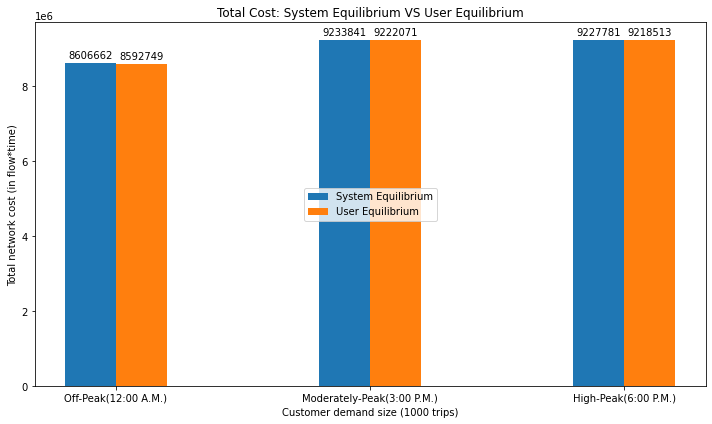

In [41]:
import numpy as np

system = [se_off, se_mod, se_high] 
user = [ue_off, ue_mod, ue_high] 

labels = ["Off-Peak(12:00 A.M.)", "Moderately-Peak(3:00 P.M.)", "High-Peak(6:00 P.M.)"]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

def autolabel(rects, ax, xpos='center'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(math.ceil(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha='center', va='bottom')

fig1, ax1 = plt.subplots(figsize=(10,6))
rects2 = ax1.bar(x - width/2, system, width, label='System Equilibrium')
rects1 = ax1.bar(x + width/2, user, width, label='User Equilibrium')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Total network cost (in flow*time)')
ax1.set_xlabel('Customer demand size (1000 trips)')
ax1.set_title('Total Cost: System Equilibrium VS User Equilibrium')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='center')

autolabel(rects1, ax1)
autolabel(rects2, ax1)
fig1.tight_layout()